# Assignment 1

## Preliminaries
Import Statements, Constant Definition, Package Installations

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
# Task 1
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from urllib.request import urlretrieve

# Task 2
import gensim
import json

import gensim.downloader as gloader
import numpy as np

from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing

# Useful during debugging (progress bars)
from tqdm import tqdm

# Typing
from typing import List, Callable, Dict

# Task 3
import tensorflow as tf

# Task 4
from sklearn.metrics import f1_score

# Task 5
import keras_tuner

from keras.optimizers import Adam
from keras.optimizers import RMSprop

#Task 6
from sklearn.preprocessing import label_binarize
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
embedding_dimension = 50
input_length = 256

## [Task 1] Corpus



### Step 1 - Download corpus

In [ ]:
# Prepare dataset location
dataset_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

root_dir = "/content"

dataset_root = os.path.join(root_dir, "dataset")
dataset_zip_path = os.path.join(dataset_root, "dependency_treebank.zip")
dataset_path = os.path.join(dataset_root, "data")

if not os.path.exists(dataset_root):
  os.mkdir(dataset_root)
if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)

In [ ]:
# Download dataset
urlretrieve(dataset_url, dataset_zip_path)

# Extract data from zip file
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
  zip_ref.extractall(dataset_path)

# Move data from subdir and remove it
temp_location = os.path.join(dataset_path, "dependency_treebank")
for element in os.listdir(temp_location):
  if element.endswith(".dp"):
    shutil.move(
        src=os.path.join(temp_location, element),
        dst=os.path.join(dataset_path, element)
    )

shutil.rmtree(temp_location)

### Step 2 - Load and split into dataframes

In [ ]:
# Prepare empty dataframes
train_df = pd.DataFrame(columns=["Sentence_ID", "Word", "POS"])
val_df = pd.DataFrame(columns=["Sentence_ID", "Word", "POS"])
test_df = pd.DataFrame(columns=["Sentence_ID", "Word", "POS"])

sentence_id = 0

# Iterate through files
for element in os.listdir(dataset_path):
  file_path = os.path.join(dataset_path, element)
  file_id = int(element[4:-3])

  # Read data from file
  with open(file_path) as f:
    # Steps performed:
    #     - strip newline character
    #     - split according to separator (\t - tab)
    #     - ignore last column
    #     - ignore empty lines
    lines = list()

    for line in f:
      if line == '\n':
        sentence_id += 1
      else:
        line = line.rstrip('\n').split('\t')[:2]
        line = [sentence_id, line[0].lower(), line[1]]
        lines.append(line)

    # Separate according to train/val/test requirements
    if 1 <= file_id <= 100:
      train_df = pd.concat([
          train_df,
          pd.DataFrame(lines, columns=train_df.columns)
      ], ignore_index=True)
    elif 101 <= file_id <= 150:
      val_df = pd.concat([
          val_df,
          pd.DataFrame(lines, columns=val_df.columns)
      ], ignore_index=True)
    else:
      test_df = pd.concat([
          test_df,
          pd.DataFrame(lines, columns=test_df.columns)
      ], ignore_index=True)

# Also obtain unified dataframe
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

### Step 3 - Data Analysis

#### Find longest sentence for input length definition

In [ ]:
max_len = 0

# Iterate through documents
for element in os.listdir(dataset_path):
  file_path = os.path.join(dataset_path, element)

  with open(file_path) as f:
    sentence_len = 0

    for line in f:
      # Sentences separated by empty line
      if line == '\n':
        if sentence_len > max_len:
          max_len = sentence_len
        sentence_len = 0
      else:
        sentence_len += 1

print("Longest sentence: " + str(max_len))

Longest sentence: 249


Since the longest sentence is 249, and we need the input_length to be greater or equal to this, we set it to a power of 2: 256.

#### Plotting the POS Distribution
The class inbalance is quite high, so we can expect that the classification will work better on better represented classes, such as NN and IN.

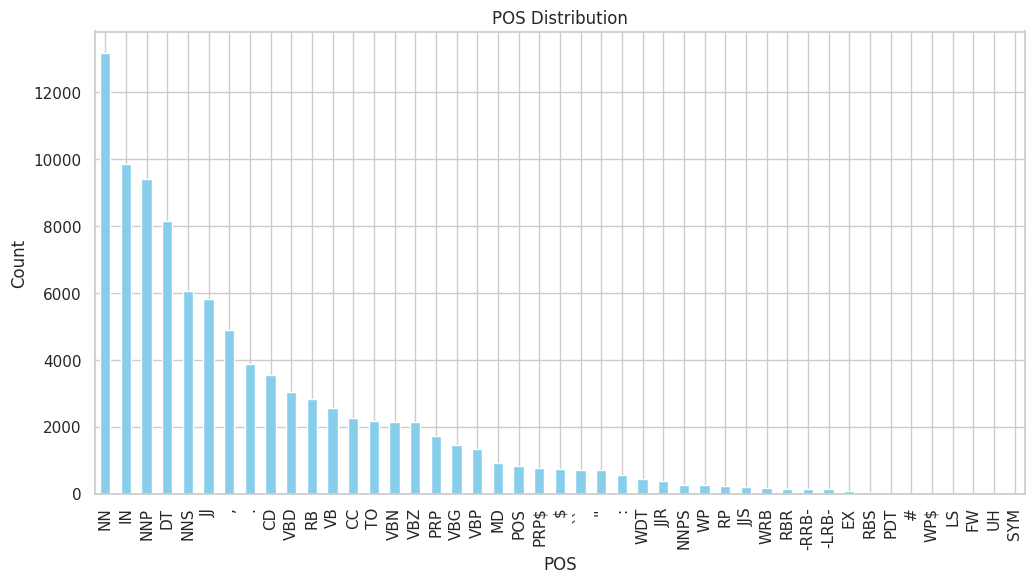

In [ ]:
tag_distribution = df['POS'].value_counts()

# Set the figure size
plt.figure(figsize=(12, 6))

sns.set(style="whitegrid")

# Plot the bar chart
tag_distribution.plot(kind='bar', color='skyblue')

plt.title('POS Distribution')
plt.xlabel('POS')
plt.ylabel('Count')
plt.show()

####Plotting the 50 most frequent words

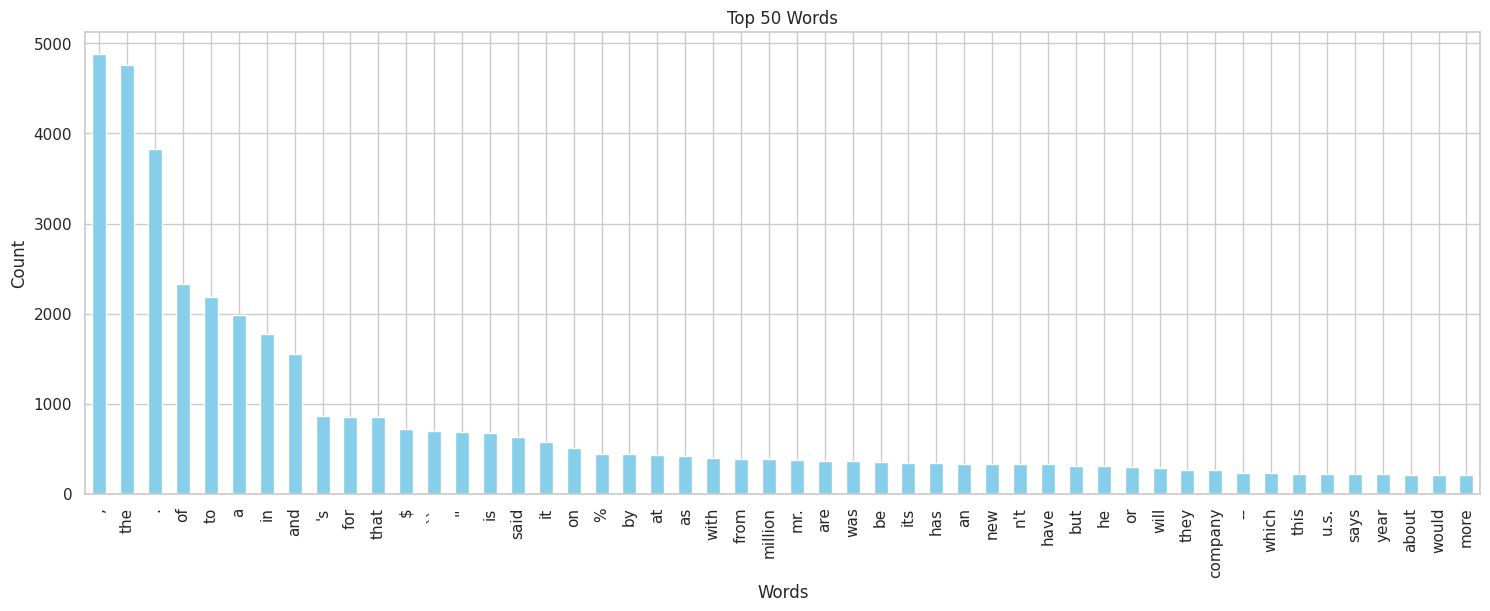

In [ ]:
# Concatenate 'Word' columns from all three DataFrames
all_words = pd.concat([train_df['Word'], val_df['Word'], test_df['Word']])

# Get the top 50 most frequent words
top_words = all_words.value_counts().head(50)

# Set the figure size
plt.figure(figsize=(18, 6))

sns.set(style="whitegrid")

# Plot the bar chart
top_words.plot(kind='bar', color='skyblue')

plt.title('Top 50 Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()

#### Plot the length of the sentences
We initially checked just the maximum sentence length, but as we can see here, that is just one exception, and maybe a different sentence length would have worked better, which could be implemented by splitting sentences longer than the input size.

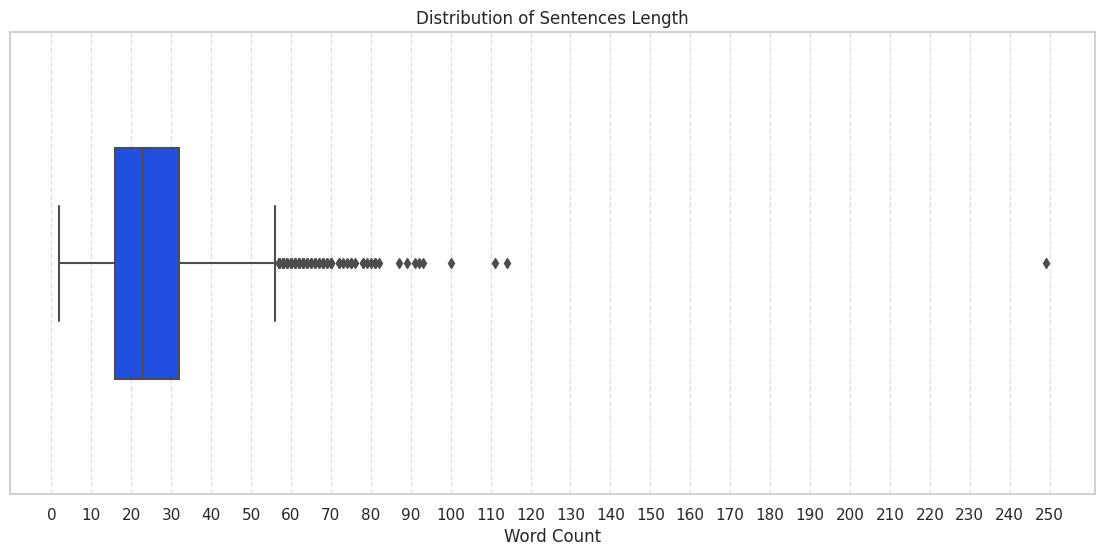

In [ ]:
sentence_lengths = df.groupby('Sentence_ID')['Word'].count()

plt.figure(figsize=(14, 6))

sns.set_theme(style="whitegrid")

colors = sns.color_palette("bright")

sns.boxplot(x=sentence_lengths, color=colors[0], width=0.5, fliersize=5)

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.title('Distribution of Sentences Length')
plt.xlabel('Word Count')

plt.xticks(ticks=range(0, max(sentence_lengths) + 10, 10))

plt.show()

## [Task 2] Text encoding

### Loading GloVe
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [ ]:
def load_embedding_model(
    embedding_dimension: int = 50
    ) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Embedding dimension must be one of: 50, 100, 200, 300")
        raise e

    return emb_model

embedding_model = load_embedding_model(embedding_dimension)

[==================================================] 100.0% 66.0/66.0MB downloaded


### Out Of Vocabulary (OOV) terms checking

In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    df: pd.DataFrame):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.index_to_key)
    oov = set(word for word in df.Word.values)
    oov = set(oov).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
oov_train = check_OOV_terms(embedding_model, train_df)
oov_percentage = float(len(oov_train)) * 100 / len(train_df)
print(f"Total OOV terms in the training set: {len(oov_train)} ({oov_percentage:.2f}%)")

oov_val = check_OOV_terms(embedding_model, val_df)
oov_percentage = float(len(oov_val)) * 100 / len(val_df)
print(f"Total OOV terms in the val set: {len(oov_val)} ({oov_percentage:.2f}%)")

oov_test = check_OOV_terms(embedding_model, test_df)
oov_percentage = float(len(oov_test)) * 100 / len(test_df)
print(f"Total OOV terms in the test set: {len(oov_test)} ({oov_percentage:.2f}%)")

Total OOV terms in the training set: 359 (0.76%)
Total OOV terms in the val set: 213 (0.68%)
Total OOV terms in the test set: 161 (1.04%)


### Vocabulary Construction

In [ ]:
tokenizer = Tokenizer(filters='', oov_token = 'UNK')
vocab = embedding_model.index_to_key + oov_train
tokenizer.fit_on_texts(vocab)

print("There are", len(tokenizer.word_index), "unique words in the created vocabulary")
print(f'Some words: {[(tokenizer.index_word[idx], idx) for idx in np.arange(10) + 1]}')

There are 400360 unique words in the created vocabulary
Some words: [('UNK', 1), ('the', 2), (',', 3), ('.', 4), ('of', 5), ('to', 6), ('and', 7), ('in', 8), ('a', 9), ('"', 10)]


### Embedding matrix construction and update

In [ ]:
def build_embedding_matrix(
    embedding_model: gensim.models.keyedvectors.KeyedVectors,
    embedding_dimension: int,
    ) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """

    embedding_matrix = np.zeros((len(tokenizer.word_index) +1, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(tokenizer.word_index.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix


In [ ]:
embedding_matrix= build_embedding_matrix(embedding_model, embedding_dimension)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 400360/400360 [00:00<00:00, 464539.31it/s]

Embedding matrix shape: (400361, 50)


### Save vocab

In [ ]:
vocab_path = os.path.join(dataset_root, 'vocab.json')

print(f"Saving vocabulary to {vocab_path}")
with open(vocab_path, mode='w') as f:
    json.dump(tokenizer.word_index, f, indent=4)
print("Saving completed!")

Saving vocabulary to /content/dataset/vocab.json
Saving completed!


### Label encoding

In [ ]:
label_encoder = preprocessing.LabelEncoder()

dataframes = [val_df, test_df]
train_df['Encoded_POS'] = label_encoder.fit_transform(train_df['POS'])

for df in dataframes:
    df['Encoded_POS'] = label_encoder.transform(df['POS'])

train_df.head(20)

,Sentence_ID,Word,POS,Encoded_POS
0,0,the,DT,10
1,0,treasury,NNP,20
2,0,said,VBD,35
3,0,it,PRP,25
4,0,plans,VBZ,39
5,0,to,TO,32
6,0,sell,VB,34
7,0,$,$,1
8,0,30,CD,9
9,0,billion,CD,9


### Now we find the Encoded POS of the punctuations
#### So we can ignore them when computing the F1 score.

In [ ]:
punctuation_classes = ["``", "’’", "-LRB-", "-RRB-", ",", ".", ":", "HYPH", "#", "$", "SYM", "''"]
classes_without_punctuation = [x for x in label_encoder.classes_ if x not in punctuation_classes]

# We find the Encoded_POS of the punctuations
encoded_punctuation = train_df[train_df['POS'].isin(punctuation_classes)]['Encoded_POS'].unique()

print(f"Punctuations that have to be avoided in the F1 score: {encoded_punctuation}")

Punctuations that have to be avoided in the F1 score: [ 1  3  6  7 44  2  4  5  0 31]


In [ ]:
# Number of unique classes that is needed to the model
num_classes = len(train_df['Encoded_POS'].unique())

### Dataset Split and Formatting

In [ ]:
def data_preparation(df, tokenizer, num_classes):
  X = list()
  y = list()

  sentence_ids = df["Sentence_ID"].unique()
  for sentence_id in sentence_ids:
    sentence_df = df[df["Sentence_ID"] == sentence_id]

    sentence_X = list(sentence_df["Word"])
    sentence_y = list(sentence_df["Encoded_POS"])

    sentence_X = tokenizer.texts_to_sequences(sentence_X)

    sentence_X += [[0]] * (256 - len(sentence_X))
    sentence_y += [0] * (256 - len(sentence_y))

    sentence_X = [int(el[0]) for el in sentence_X]
    sentence_y = np.eye(num_classes)[sentence_y]

    X.append(np.array(sentence_X))
    y.append(sentence_y)

  X = np.array(X)
  y = np.array(y)

  return X, y

In [ ]:
x_train, y_train = data_preparation(train_df, tokenizer, num_classes)

#Training shape
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')

X train shape: (1914, 256)
Y train shape: (1914, 256, 45)


In [ ]:
x_val, y_val = data_preparation(val_df, tokenizer, num_classes)

# Validation shape
print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')

X val shape: (1285, 256)
Y val shape: (1285, 256, 45)


In [ ]:
x_test, y_test = data_preparation(test_df, tokenizer, num_classes)

# Test shape
print(f'X test shape: {x_test.shape}')
print(f'Y test shape: {y_test.shape}')

X test shape: (641, 256)
Y test shape: (641, 256, 45)


In [ ]:
# Making sure the vocabulary has same size as the embedding matrix
vocab_size = len(tokenizer.word_index) + 1

## [Task 3] Model definition

### Baseline
Encoder + 1 LSTM + 1 Fully Connected

In [ ]:
def create_baseline(units, activation, learning_rate):
    baseline_model = tf.keras.Sequential()

    # Start from common root model
    baseline_model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dimension,
        input_length=input_length,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True))

    baseline_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
       units=units,
       activation = activation,
       return_sequences=True)))

    # Add output layer and compile model
    baseline_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    baseline_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    baseline_model.summary()
    return baseline_model

### Model 1
Encoder + 2 LSTM + 1 Fully Connected

As we will see in the next section, this is the best performing model, so we choose this one to also examine the improvement the TimeDistributed layer brings.

In [ ]:
def create_model1(units, units_2, activation, learning_rate):
    model1 = tf.keras.Sequential()

    # Start from common root model
    model1.add(tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dimension,
          input_length=input_length,
          weights=[embedding_matrix],
          mask_zero=True,
          trainable=True))

    model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
         units=units,
         activation = activation,
         return_sequences=True)))

    # Add extra LSTM layer
    model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
           units=units_2,
           activation = activation,
           return_sequences=True)))

    # Add output layer and compile model
    model1.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model1.compile(
         optimizer=Adam(learning_rate=learning_rate),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

    model1.summary()
    return model1

Model1 version with **TimeDistributed** layer

In [ ]:
def create_model1_timedist(units, units_2, activation, learning_rate):
    model1 = tf.keras.Sequential()

    # Start from common root model
    model1.add(tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dimension,
          input_length=input_length,
          weights=[embedding_matrix],
          mask_zero=True,
          trainable=True))

    model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
         units=units,
         activation = activation,
         return_sequences=True)))

    # Add extra LSTM layer
    model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
           units=units_2,
           activation = activation,
           return_sequences=True)))

    # Add output layer and compile model
    model1.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_classes, activation='softmax')))

    model1.compile(
         optimizer=Adam(learning_rate=learning_rate),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

    model1.summary()
    return model1

### Model 2
Encoder + 1 LSTM + 2 Fully Connected

In [ ]:
def create_model2(units, units_2, activation, learning_rate):
    model2 = tf.keras.Sequential()

    # Start from common root model
    model2.add(tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dimension,
          input_length=input_length,
          weights=[embedding_matrix],
          mask_zero=True,
          trainable=True))

    model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
         units=units,
         activation = activation,
         return_sequences=True)))

    # Add extra dense layer
    model2.add(tf.keras.layers.Dense(units_2, activation='relu'))

    # Add output model and compile model
    model2.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model2.compile(
        optimizer=Adam(learning_rate = learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    model2.summary()
    return model2

## [Task 4] Metrics

In [ ]:
def transform_labels(y_true, y_pred):

  #reverse transformation from one hot encoding
  y_true = np.argmax(y_true, axis = -1).flatten()
  y_pred = np.argmax(y_pred, axis = -1).flatten()

  #ignore zero padding
  y_pred[np.where(y_true==0)] = 0

  return y_true, y_pred

In [ ]:
def macro_f1_score(y_true, y_pred):

  labels = set(y_true).union(set(y_pred))
  labels -= set(encoded_punctuation)
  labels = list(labels)
  score = f1_score(y_true, y_pred, average ='macro', labels=labels)
  return score

## [Task 5] Training and Evaluation

### Training Models

We use the keras_tuner library to look for the best hyperparameters for each model. We use the Hyperband method. We experiment with activations (try both relu, and tanh), leraning rate values, and number of units in the hidden layers.

As requested, we use the validation set for an initial evaluation.

#### We define the function to plot the Loss and Accuracy of the Validation set

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_data(history):

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(y=history.history['val_loss'], name="val_loss"),
        secondary_y=False,
    )

    fig.add_trace(
       go.Scatter(y=history.history['val_accuracy'], name="val accuracy"),
       secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
       title_text="Loss/Accuracy of the Model"
    )

    # Set x-axis title
    fig.update_xaxes(title_text="<b>Epoch</b>")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Loss</b>", secondary_y=False)
    fig.update_yaxes(title_text="<b>Accuracy</b>", secondary_y=True)

    fig.show()

#### We define the callbacks that we are gonna use in the training

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callback = EarlyStopping(monitor = 'val_accuracy', min_delta=0.001, patience = 4, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=5)

#### Parameter search

##### **Baseline Model**

In [ ]:
# Build model compatible with keras_tuner
def build_baseline(hp):
    units = hp.Int("units", min_value=32, max_value=128, step=16)

    activation = hp.Choice("activation", ["relu", "tanh"])

    learning_rate = hp.Float(
        "learning_rate",
        min_value=1e-4,
        max_value=1e-2,
        sampling="log")

    model = create_baseline(
        units = units,
        activation = activation ,
        learning_rate = learning_rate)

    return model

In [ ]:
# Prepare directory to save search results
if not os.path.exists("./models"):
    os.makedirs("./models")

# Prepare tuner object
tuner = keras_tuner.Hyperband(
    hypermodel=build_baseline,
    objective= "val_accuracy",
    max_epochs=10,
    directory='./models',
    project_name='baseline')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 50)           20018050  
                                                                 
 bidirectional (Bidirection  (None, 256, 64)           21248     
 al)                                                             
                                                                 
 dense (Dense)               (None, 256, 45)           2925      
                                                                 
Total params: 20042223 (76.46 MB)
Trainable params: 20042223 (76.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Perform search
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val,y_val))
best_model = tuner.get_best_models()[0]
tuner.results_summary()

Trial 30 Complete [00h 01m 39s]
val_accuracy: 0.461950421333313

Best val_accuracy So Far: 0.9181926250457764
Total elapsed time: 01h 15m 14s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 50)           20018050  
                                                                 
 bidirectional (Bidirection  (None, 256, 96)           38016     
 al)                                                             
                                                                 
 dense (Dense)               (None, 256, 45)           4365      
                                                                 
Total params: 20060431 (76.52 MB)
Trainable params: 20060431 (76.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Results summary
Results in ./models/baseline
Showing 10 best trials
Ob

In [ ]:
# Create model based on best hyperparams
baseline_model = create_baseline(
    units=48,
    activation="tanh",
    learning_rate=0.005862125721808125)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 50)           20018050  
                                                                 
 bidirectional_4 (Bidirecti  (None, 256, 96)           38016     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 256, 45)           4365      
                                                                 
Total params: 20060431 (76.52 MB)
Trainable params: 20060431 (76.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training of the **Baseline Model**

In [ ]:
seeds = [42, 123, 999]
num_epochs = 10
baseline_models = {}
test_accuracies = []

for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)

    baseline_model = create_baseline(
        units=48,
        activation="tanh",
        learning_rate=0.005862125721808125)

    baseline_history = baseline_model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_val, y_val), callbacks = [callback,reduce_lr])

    baseline_models[seed] = baseline_model

    evaluation = baseline_model.evaluate(x_test, y_test)

    y_pred = baseline_model.predict(x_test)
    y_true, y_pred = transform_labels(y_test, y_pred)
    test_f1 = macro_f1_score(y_true, y_pred)

    y_pred_val = baseline_model.predict(x_val)
    y_true_val, y_pred_val = transform_labels(y_val, y_pred_val)
    val_f1 = macro_f1_score(y_true_val, y_pred_val)

    test_accuracy = evaluation[1]
    test_accuracies.append(test_accuracy)

    print(f"Seed {seed}: Test loss = {evaluation[0]}, Test accuracy = {evaluation[1]}, Test f1 score = {test_f1}, Validation f1 score = {val_f1}")

print("Test Accuracies for All Seeds:", test_accuracies)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 256, 50)           20018050  
                                                                 
 bidirectional_6 (Bidirecti  (None, 256, 96)           38016     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 256, 45)           4365      
                                                                 
Total params: 20060431 (76.52 MB)
Trainable params: 20060431 (76.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
60/60 [==============================] - 23s 222ms/step - loss: 1.7196 - accuracy: 0.5571 - val_loss: 0.6658 - val_accuracy: 0.8221 - lr: 0.0059
Epoch 2/10
60/60 [==============================] - 6s

In [ ]:
# we create the folder in order to save the weights
weights_folder = 'weights'
weights_path = os.path.join(os.getcwd(), weights_folder)

if not os.path.exists(weights_path):
    os.mkdir(weights_path)

baseline_path = os.path.join(weights_path, 'baseline')
model1_path = os.path.join(weights_path, 'model1')
model1_timedist_path = os.path.join(weights_path, 'model1_timedist')
model2_path = os.path.join(weights_path, 'model2')

if not os.path.exists(baseline_path):
    os.mkdir(baseline_path)

if not os.path.exists(model1_path):
    os.mkdir(model1_path)

if not os.path.exists(model1_timedist_path):
    os.mkdir(model1_timedist_path)

if not os.path.exists(model2_path):
    os.mkdir(model2_path)

In [ ]:
# Existing weights preparing
baseline_url =        "https://drive.google.com/uc?export=download&id=1cu30AuQKM7VkCcdqCzaJjX09lmUsqCEV"
model1_url =          "https://drive.google.com/uc?export=download&id=1WiGhMop6oyRw3pNVl2GC3M7vBiBsWUUX"
model1_timedist_url = "https://drive.google.com/uc?export=download&id=1NqPtY2CdeQCB2_yCVmDycjCtRGsO1JS7"
model2_url =          "https://drive.google.com/uc?export=download&id=1cI-2FfZcGwS-1yRl4jiFHuMnJFBOcOZD"

baseline_path = os.path.join(baseline_path, "baseline.h5")
model1_path = os.path.join(model1_path, "model1.h5")
model1_timedist_path = os.path.join(model1_timedist_path, "model1_timedist.h5")
model2_path = os.path.join(model2_path, "model2.h5")

urlretrieve(baseline_url, baseline_path)
urlretrieve(model1_url, model1_path)
urlretrieve(model1_timedist_url, model1_timedist_path)
urlretrieve(model2_url, model2_path);

In [ ]:
# Run this only if you want to save the weights after having trained the model.
# Otherwise just download the existing weights above.
baseline_w_path = os.path.join(baseline_path, 'baseline' + '.h5')
baseline_model.save_weights(baseline_w_path)
print("Saved!")

Saved!


Plot the Accuracy and Loss of the Validation set obtained with the **Baseline Model**

In [ ]:
plot_data(baseline_history)

##### **Model 1**

Encoder + 2 LSTM + 1 Fully Connected

In [ ]:
# Build model compatible with keras_tuner
def build_model1(hp):
    units = hp.Int("units", min_value=32, max_value=128, step=16)
    units_2 = hp.Int("units_2", min_value=32, max_value=128, step=16)

    activation = hp.Choice("activation", ["relu", "tanh"])

    learning_rate = hp.Float(
        "learning_rate",
        min_value=1e-4,
        max_value=1e-2,
        sampling="log")

    model = create_model1(
        units=units,
        units_2=units_2,
        activation = activation ,
        learning_rate = learning_rate)

    return model

In [ ]:
# Prepare directory to save search results
if not os.path.exists("./models"):
    os.makedirs("./models")

# Prepare tuner object
tuner = keras_tuner.Hyperband(
    hypermodel=build_model1,
    objective= "val_accuracy",
    max_epochs=10,
    directory='./models',
    project_name='model1')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 50)           20018050  
                                                                 
 bidirectional (Bidirection  (None, 256, 64)           21248     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256, 64)           24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 256, 45)           2925      
                                                                 
Total params: 20067055 (76.55 MB)
Trainable params: 20067055 (76.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Perform search
tuner.search(x_train,y_train, epochs=10, validation_data=(x_val,y_val))
best_model = tuner.get_best_models()[0]
tuner.results_summary()

Trial 30 Complete [00h 02m 41s]
val_accuracy: 0.5632556080818176

Best val_accuracy So Far: 0.921816349029541
Total elapsed time: 01h 46m 10s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 50)           20018050  
                                                                 
 bidirectional (Bidirection  (None, 256, 128)          58880     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256, 192)          172800    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 256, 45)           8685      
                                                                 
Total params: 20258415 (77.28 MB)
Trainable pa

In [ ]:
# We create the model here in order to simply load the weights in part 6 avoiding to run the training
model1 = create_model1(
        units=64,
        units_2=96,
        activation="tanh",
        learning_rate=0.009493934795032574)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 50)           20018050  
                                                                 
 bidirectional (Bidirection  (None, 256, 128)          58880     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256, 192)          172800    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 256, 45)           8685      
                                                                 
Total params: 20258415 (77.28 MB)
Trainable params: 20258415 (77.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training of **Model1**

In [ ]:
seeds = [42, 123, 999]
num_epochs = 10
models_1 = {}
test_accuracies = []

for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model1 = create_model1(
            units=64,
            units_2=96,
            activation="tanh",
            learning_rate=0.009493934795032574)

    model1_history = model1.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_val, y_val), callbacks = [callback,reduce_lr])

    models_1[seed] = model1

    evaluation = model1.evaluate(x_test, y_test)

    y_pred = model1.predict(x_test)
    y_true, y_pred = transform_labels(y_test, y_pred)
    test_f1 = macro_f1_score(y_true, y_pred)

    y_pred_val = model1.predict(x_val)
    y_true_val, y_pred_val = transform_labels(y_val, y_pred_val)
    val_f1 = macro_f1_score(y_true_val, y_pred_val)

    test_accuracy = evaluation[1]
    test_accuracies.append(test_accuracy)

    print(f"Seed {seed}: Test loss = {evaluation[0]}, Test accuracy = {evaluation[1]}, Test f1 score = {test_f1}, Validation f1 score = {val_f1}")

print("Test Accuracies for All Seeds:", test_accuracies)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 256, 50)           20018050  
                                                                 
 bidirectional_6 (Bidirecti  (None, 256, 128)          58880     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 256, 192)          172800    
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 256, 45)           8685      
                                                                 
Total params: 20258415 (77.28 MB)
Trainable params: 20258415 (77.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
6

In [ ]:
#we save the weights
model1_w_path = os.path.join(model1_path, 'model1' + '.h5')
model1.save_weights(model1_w_path)
print("Saved!")

Saved!


Plot the results of **Model1**

In [ ]:
plot_data(model1_history)

#####**Model1** with **TimeDistributed** Layer

In [ ]:
model1_timedist = create_model1_timedist(
        units=64,
        units_2=96,
        activation="tanh",
        learning_rate=0.009493934795032574)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 50)           20018050  
                                                                 
 bidirectional_2 (Bidirecti  (None, 256, 128)          58880     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256, 192)          172800    
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 256, 45)           8685      
 ributed)                                                        
                                                                 
Total params: 20258415 (77.28 MB)
Trainable params: 20258415 (77.28 MB)
Non-trainable params: 0 (0.00 Byte)
____________

Training of **model1** with **TimeDistributed** Layer

In [ ]:
seeds = [42, 123, 999]
num_epochs = 10
models_1_timedist = {}
test_accuracies = []

for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model1_timedist = create_model1_timedist(
            units=64,
            units_2=96,
            activation="tanh",
            learning_rate=0.009493934795032574)

    model1_timedist_history = model1_timedist.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_val, y_val), callbacks = [callback,reduce_lr])

    models_1_timedist[seed] = model1_timedist

    evaluation = model1_timedist.evaluate(x_test, y_test)

    y_pred = model1_timedist.predict(x_test)
    y_true, y_pred = transform_labels(y_test, y_pred)
    test_f1 = macro_f1_score(y_true, y_pred)

    y_pred_val = model1_timedist.predict(x_val)
    y_true_val, y_pred_val = transform_labels(y_val, y_pred_val)
    val_f1 = macro_f1_score(y_true_val, y_pred_val)

    test_accuracy = evaluation[1]
    test_accuracies.append(test_accuracy)

    print(f"Seed {seed}: Test loss = {evaluation[0]}, Test accuracy = {evaluation[1]}, Test f1 score = {test_f1}, Validation f1 score = {val_f1}")

print("Test Accuracies for All Seeds:", test_accuracies)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 256, 50)           20018050  
                                                                 
 bidirectional_14 (Bidirect  (None, 256, 128)          58880     
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 256, 192)          172800    
 ional)                                                          
                                                                 
 time_distributed_1 (TimeDi  (None, 256, 45)           8685      
 stributed)                                                      
                                                                 
Total params: 20258415 (77.28 MB)
Trainable params: 20258415 (77.28 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [ ]:
#we save model1_timedist weights
model1_timedist_w_path = os.path.join(model1_timedist_path, 'model1_timedist' + '.h5')
model1_timedist.save_weights(model1_timedist_w_path)
print("Saved!")

Saved!


In [ ]:
plot_data(model1_timedist_history)

##### **Model 2**

Encoder + 1 LSTM + 2 Fully Connected

In [ ]:
# Build model compatible with keras_tuner
def build_model2(hp):
    units = hp.Int("units", min_value=32, max_value=128, step=16)

    # Go through: 128, 256, 512, 1024
    units_2 = hp.Int(
        "units_2",
        min_value=128,
        max_value=1024,
        step=2,
        sampling="log")

    activation = hp.Choice("activation", ["relu", "tanh"])

    learning_rate = hp.Float(
        "learning_rate",
        min_value=1e-4,
        max_value=1e-2,
        sampling="log")

    model = create_model2(
        units=units,
        units_2=units_2,
        activation=activation,
        learning_rate=learning_rate)

    return model

In [ ]:
# Prepare directory to save search results
if not os.path.exists("./models"):
    os.makedirs("./models")

# Prepare tuner object
tuner = keras_tuner.Hyperband(hypermodel=build_model2,
                            objective= "val_accuracy",
                            max_epochs=10,
                            directory='./models',
                            project_name='model2')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 50)           20018050  
                                                                 
 bidirectional_1 (Bidirecti  (None, 256, 64)           21248     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 256, 128)          8320      
                                                                 
 dense_3 (Dense)             (None, 256, 45)           5805      
                                                                 
Total params: 20053423 (76.50 MB)
Trainable params: 20053423 (76.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Perform search
tuner.search(x_train,y_train, epochs=10, validation_data=(x_val,y_val))
best_model = tuner.get_best_models()[0]
tuner.results_summary()

Trial 30 Complete [00h 01m 43s]
val_accuracy: 0.7359779477119446

Best val_accuracy So Far: 0.9188981056213379
Total elapsed time: 02h 20m 42s


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 50)           20018050  
                                                                 
 bidirectional (Bidirection  (None, 256, 224)          146048    
 al)                                                             
                                                                 
 dense (Dense)               (None, 256, 512)          115200    
                                                                 
 dense_1 (Dense)             (None, 256, 45)           23085     
                                                                 
Total params: 20302383 (77.45 MB)
Trainable params: 20302383 (77.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Results summary
Results in ./models/model2
Showing 10 best trials
Objective(name

In [ ]:
model2 = create_model2(
    units=112,
    units_2=512,
    activation="relu",
    learning_rate=0.004113819084881901)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 256, 50)           20018050  
                                                                 
 bidirectional_20 (Bidirect  (None, 256, 224)          146048    
 ional)                                                          
                                                                 
 dense_12 (Dense)            (None, 256, 512)          115200    
                                                                 
 dense_13 (Dense)            (None, 256, 45)           23085     
                                                                 
Total params: 20302383 (77.45 MB)
Trainable params: 20302383 (77.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training **Model2**

In [ ]:
seeds = [42, 123, 999]
num_epochs = 10
models_2 = {}
test_accuracies = []

for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model2 = create_model2(
      units=112,
      units_2=512,
      activation="relu",
      learning_rate=0.004113819084881901)

    model2_history = model2.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_val, y_val), callbacks = [callback,reduce_lr])

    models_2[seed] = model2

    evaluation = model2.evaluate(x_test, y_test)

    y_pred = model2.predict(x_test)
    y_true, y_pred = transform_labels(y_test, y_pred)
    test_f1 = macro_f1_score(y_true, y_pred)

    y_pred_val = model2.predict(x_val)
    y_true_val, y_pred_val = transform_labels(y_val, y_pred_val)
    val_f1 = macro_f1_score(y_true_val, y_pred_val)

    test_accuracy = evaluation[1]
    test_accuracies.append(test_accuracy)

    print(f"Seed {seed}: Test loss = {evaluation[0]}, Test accuracy = {evaluation[1]}, Test f1 score = {test_f1}, Validation f1 score = {val_f1}")

print("Test Accuracies for All Seeds:", test_accuracies)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 256, 50)           20018050  
                                                                 
 bidirectional_21 (Bidirect  (None, 256, 224)          146048    
 ional)                                                          
                                                                 
 dense_14 (Dense)            (None, 256, 512)          115200    
                                                                 
 dense_15 (Dense)            (None, 256, 45)           23085     
                                                                 
Total params: 20302383 (77.45 MB)
Trainable params: 20302383 (77.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
60/60 [==============================] - 97s 2s/step - loss: 1.550

Seed 42: Test loss = 0.27252498269081116, Test accuracy = 0.9271148443222046, Test f1 score = 0.8616988034269942, Validation f1 score = 0.8061314529273856
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 256, 50)           20018050  
                                                                 
 bidirectional_22 (Bidirect  (None, 256, 224)          146048    
 ional)                                                          
                                                                 
 dense_16 (Dense)            (None, 256, 512)          115200    
                                                                 
 dense_17 (Dense)            (None, 256, 45)           23085     
                                                                 
Total params: 20302383 (77.45 MB)
Trainable params: 20302383 (77.45 MB)
Non-trainable params: 0 

Seed 123: Test loss = 0.32529690861701965, Test accuracy = 0.9159858226776123, Test f1 score = 0.820877245851856, Validation f1 score = 0.7522942907547492
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 256, 50)           20018050  
                                                                 
 bidirectional_23 (Bidirect  (None, 256, 224)          146048    
 ional)                                                          
                                                                 
 dense_18 (Dense)            (None, 256, 512)          115200    
                                                                 
 dense_19 (Dense)            (None, 256, 45)           23085     
                                                                 
Total params: 20302383 (77.45 MB)
Trainable params: 20302383 (77.45 MB)
Non-trainable params: 0 

In [ ]:
#we save model2 weights
model2_w_path = os.path.join(model2_path, 'model2' + '.h5')
model2.save_weights(model2_w_path)
print("Saved!")

Saved!


In [ ]:
plot_data(model2_history)

In [ ]:
#Let's see the accuracy and the loss of the 4 Models
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=baseline_history.history['val_loss'], name="val_loss_baseline"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=model1_history.history['val_loss'], name="val_loss_model1"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=model1_timedist_history.history['val_loss'], name="val_loss_model1_timedist"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=model2_history.history['val_loss'], name="val_loss_model2"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=baseline_history.history['val_accuracy'], name="val accuracy_baseline"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=model1_history.history['val_accuracy'], name="val_accuracy_model1"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=model1_timedist_history.history['val_accuracy'], name="val_accuracy_model1_timedist"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=model2_history.history['val_accuracy'], name="val_accuracy_model2"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of the Four Models"
)

# Set x-axis title
fig.update_xaxes(title_text="<b>Epoch</b>")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Loss</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Accuracy</b>", secondary_y=True)

fig.show()

According to the validation accuracy, **Model1** is the best performing model.

That's why we are going to do the error analysis of both the **model1** and also the **model1** with **TimeDistributed** Layer.

## [Task 6] Error Analysis

Let's see the distribution of the POS tags in the 3 sets

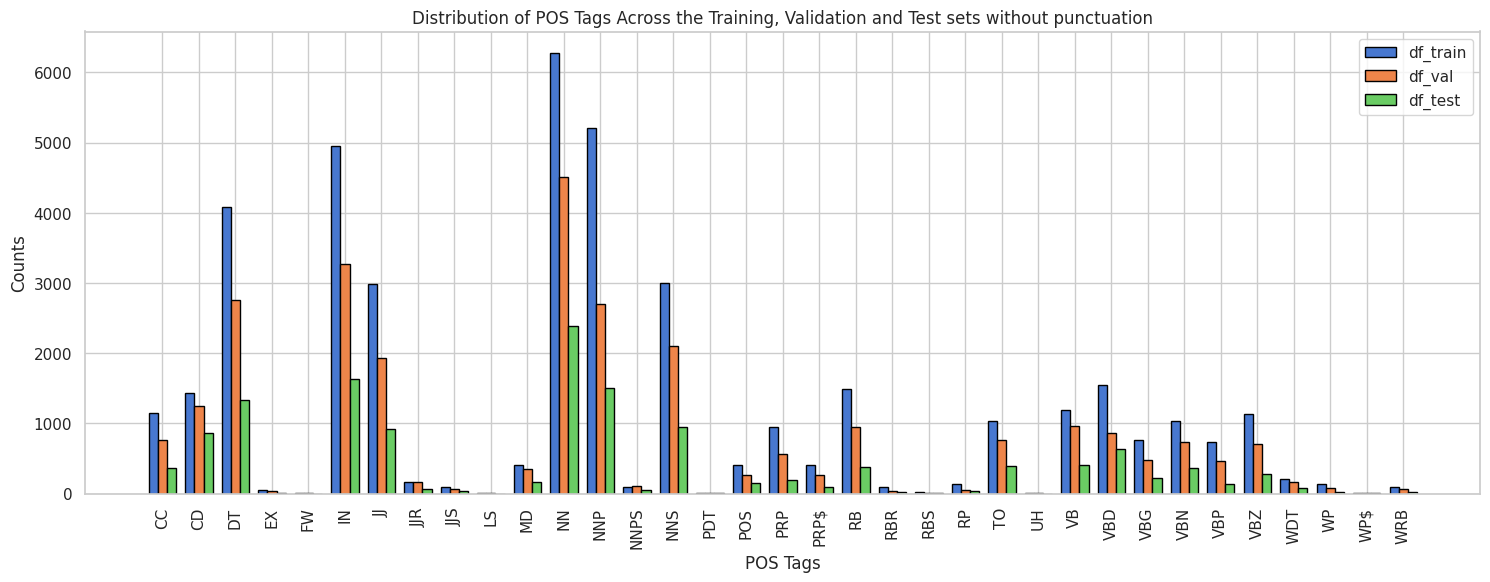

In [ ]:
all_values = [train_df.POS[np.logical_not(train_df["POS"].isin(punctuation_classes))],
              val_df.POS[np.logical_not(val_df["POS"].isin(punctuation_classes))],
              test_df.POS[np.logical_not(test_df["POS"].isin(punctuation_classes))]]

# Count frequencies of POS tags in each DataFrame
freq_train = all_values[0].value_counts()
freq_val = all_values[1].value_counts()
freq_test = all_values[2].value_counts()

# Get unique POS tags
all_POS_tags = np.unique(np.concatenate(all_values))

# Creating positions for bars
bar_width = 0.25
r1 = np.arange(len(all_POS_tags))

palette = sns.color_palette('muted', 3)

plt.figure(figsize=(18, 6))

plt.bar(r1, [freq_train.get(pos, 0) for pos in all_POS_tags], color=palette[0], width=bar_width, edgecolor='black', label='df_train')
plt.bar(r1 + bar_width, [freq_val.get(pos, 0) for pos in all_POS_tags], color=palette[1], width=bar_width, edgecolor='black', label='df_val')
plt.bar(r1 + (2 * bar_width), [freq_test.get(pos, 0) for pos in all_POS_tags], color=palette[2], width=bar_width, edgecolor='black', label='df_test')

plt.xlabel('POS Tags')
plt.ylabel('Counts')
plt.title('Distribution of POS Tags Across the Training, Validation and Test sets without punctuation')
plt.xticks(r1 + bar_width, all_POS_tags, rotation='vertical')
plt.legend()
plt.show()

We start inspecting the performance of our best model on the test set by means of the classification report and the confusion matrix.

In [ ]:
model1_w_path = os.path.join(model1_path)
model1.load_weights(model1_w_path, skip_mismatch=False, by_name=False, options=None)

In [ ]:
model1_timedist_w_path = os.path.join(model1_timedist_path)
model1_timedist.load_weights(model1_timedist_w_path, skip_mismatch=False, by_name=False, options=None)

In [ ]:
y_pred = model1.predict(x_val)
y_true_val, y_pred_val = transform_labels(y_val, y_pred)

y_true_val_inv = label_encoder.inverse_transform(y_true_val)
y_pred_val_inv = label_encoder.inverse_transform(y_pred_val)

print("Classification Report of Model 1 for Validation Set", "\n" *2, classification_report(y_true_val_inv, y_pred_val_inv, zero_division=0, labels = classes_without_punctuation))

41/41 [==============================] - 10s 10ms/step
Classification Report of Model 1 for Validation Set 

               precision    recall  f1-score   support

          CC       0.99      0.99      0.99       758
          CD       0.95      0.90      0.93      1249
          DT       0.99      0.99      0.99      2754
          EX       0.97      1.00      0.99        34
          FW       0.00      0.00      0.00         2
          IN       0.99      0.97      0.98      3275
          JJ       0.74      0.88      0.80      1924
         JJR       0.91      0.85      0.88       165
         JJS       0.88      0.78      0.83        58
          LS       0.00      0.00      0.00         3
          MD       1.00      0.98      0.99       347
          NN       0.88      0.89      0.88      4513
         NNP       0.86      0.86      0.86      2704
        NNPS       0.69      0.10      0.18       105
         NNS       0.91      0.88      0.90      2102
         PDT       0.89  

In [ ]:
y_pred = model1.predict(x_test)
y_true_test, y_pred_test = transform_labels(y_test, y_pred)

y_true_test_inv = label_encoder.inverse_transform(y_true_test)
y_pred_test_inv = label_encoder.inverse_transform(y_pred_test)

print("Classification Report of Model 1 for Test Set", "\n" *2, classification_report(y_true_test_inv, y_pred_test_inv, zero_division=0, labels = classes_without_punctuation))

21/21 [==============================] - 0s 11ms/step
Classification Report of Model 1 for Test Set 

               precision    recall  f1-score   support

          CC       0.99      1.00      1.00       366
          CD       0.96      0.92      0.94       858
          DT       0.99      0.99      0.99      1335
          EX       1.00      1.00      1.00         5
          FW       0.00      0.00      0.00         0
          IN       0.98      0.96      0.97      1630
          JJ       0.73      0.86      0.79       918
         JJR       0.79      0.92      0.85        59
         JJS       0.93      0.84      0.88        31
          LS       0.00      0.00      0.00         0
          MD       0.98      1.00      0.99       167
          NN       0.89      0.87      0.88      2383
         NNP       0.87      0.87      0.87      1504
        NNPS       0.29      0.05      0.08        44
         NNS       0.91      0.92      0.91       941
         PDT       1.00      0.2

Now let's see the classification report of the **model1** with TimeDistributed Layer

In [ ]:
y_pred_timedist = model1_timedist.predict(x_test)
y_true_test2, y_pred_test2 = transform_labels(y_test, y_pred_timedist)

y_true_test_inv2 = label_encoder.inverse_transform(y_true_test2)
y_pred_test_inv2 = label_encoder.inverse_transform(y_pred_test2)

print("Classification Report of Model 1 with TimeDistributed Layer", "\n" *2, classification_report(y_true_test_inv2, y_pred_test_inv2, zero_division=0, labels = classes_without_punctuation))

21/21 [==============================] - 0s 10ms/step
Classification Report of Model 1 with TimeDistributed Layer 

               precision    recall  f1-score   support

          CC       0.99      1.00      0.99       366
          CD       0.98      0.94      0.96       858
          DT       1.00      0.99      0.99      1335
          EX       0.83      1.00      0.91         5
          FW       0.00      0.00      0.00         0
          IN       0.98      0.96      0.97      1630
          JJ       0.77      0.86      0.81       918
         JJR       0.79      0.90      0.84        59
         JJS       1.00      0.94      0.97        31
          LS       0.00      0.00      0.00         0
          MD       0.98      1.00      0.99       167
          NN       0.90      0.87      0.88      2383
         NNP       0.88      0.87      0.87      1504
        NNPS       0.40      0.05      0.08        44
         NNS       0.90      0.92      0.91       941
         PDT      

We can notice two things from these classification reports:
1.   There are POS tags which have support = 0 in the test set and resulting in zeros everywhere, these tags are:

     *   **UH**
     *   **LS**
     *   **FW**

Even in the validation set where we can see some samples of these classes, we get the same result (zero precision, recall and f1 score)

We can check the training set to see if we have enough number of samples for these 3 classes for the model to learn:



In [ ]:
print("Number of samples for class 'UH' in training set: ", len(train_df[(train_df['POS']=='UH')]))
print("Number of samples for class 'LS' in training set: ", len(train_df[(train_df['POS']=='LS')]))
print("Number of samples for class 'FW' in training set: ", len(train_df[(train_df['POS']=='FW')]))

Number of samples for class 'UH' in training set:  1
Number of samples for class 'LS' in training set:  10
Number of samples for class 'FW' in training set:  2


2.   The following tags have a low F1-score, which means that the model makes mistakes when trying to classify them:

     *    **NNPS**
     *    **PDT**
     *    **RBR**

As we can see in the confusion matrix below, the model tends to mistake the classification of the **NNPS** with **NNP** and **NNS**.

Since we have such a low F1-score for the **NNPS** we will have a look more in detail to it.

For the **PDT** we can see that there are only 4 tokens of it so it explains the low F1-score.


Another error that we can notice by inspecting the confusion matrix is the **RBR/JJR**.


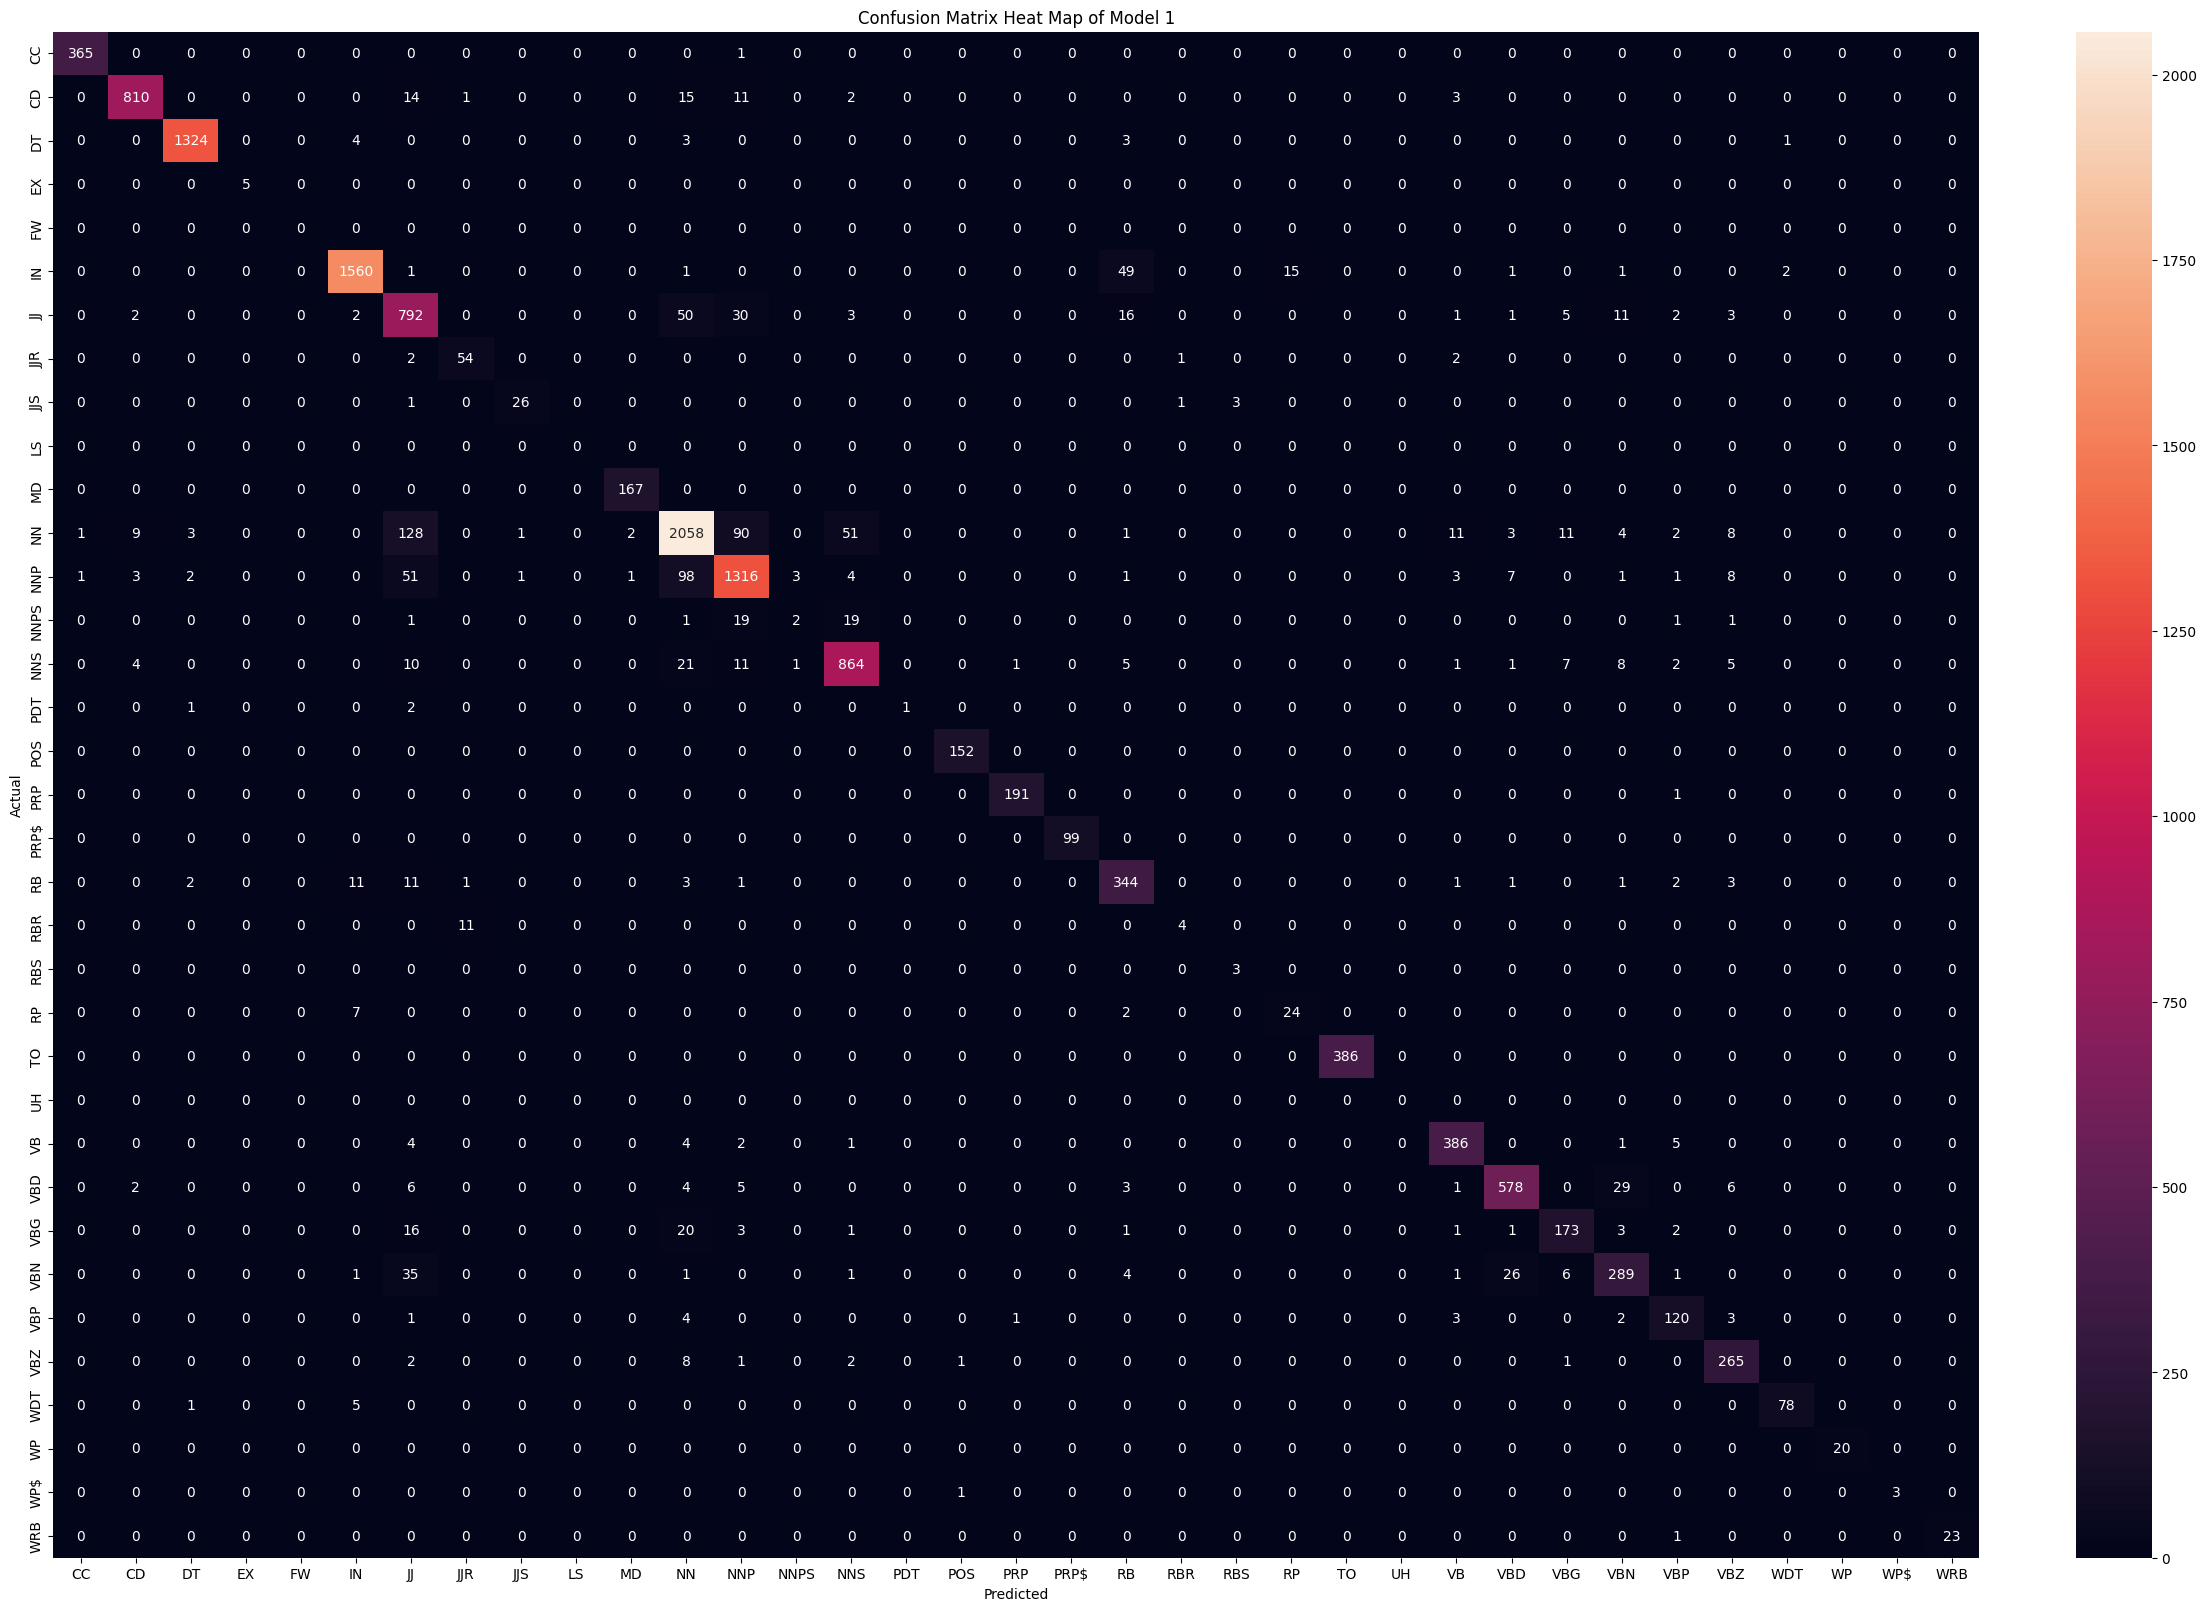

In [ ]:
cm = confusion_matrix(y_true_test_inv, y_pred_test_inv, labels = classes_without_punctuation)
fig, ax = plt.subplots(figsize=(22,16), layout = 'constrained')
sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes_without_punctuation, yticklabels=classes_without_punctuation)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heat Map of Model 1')
plt.show(block=False)

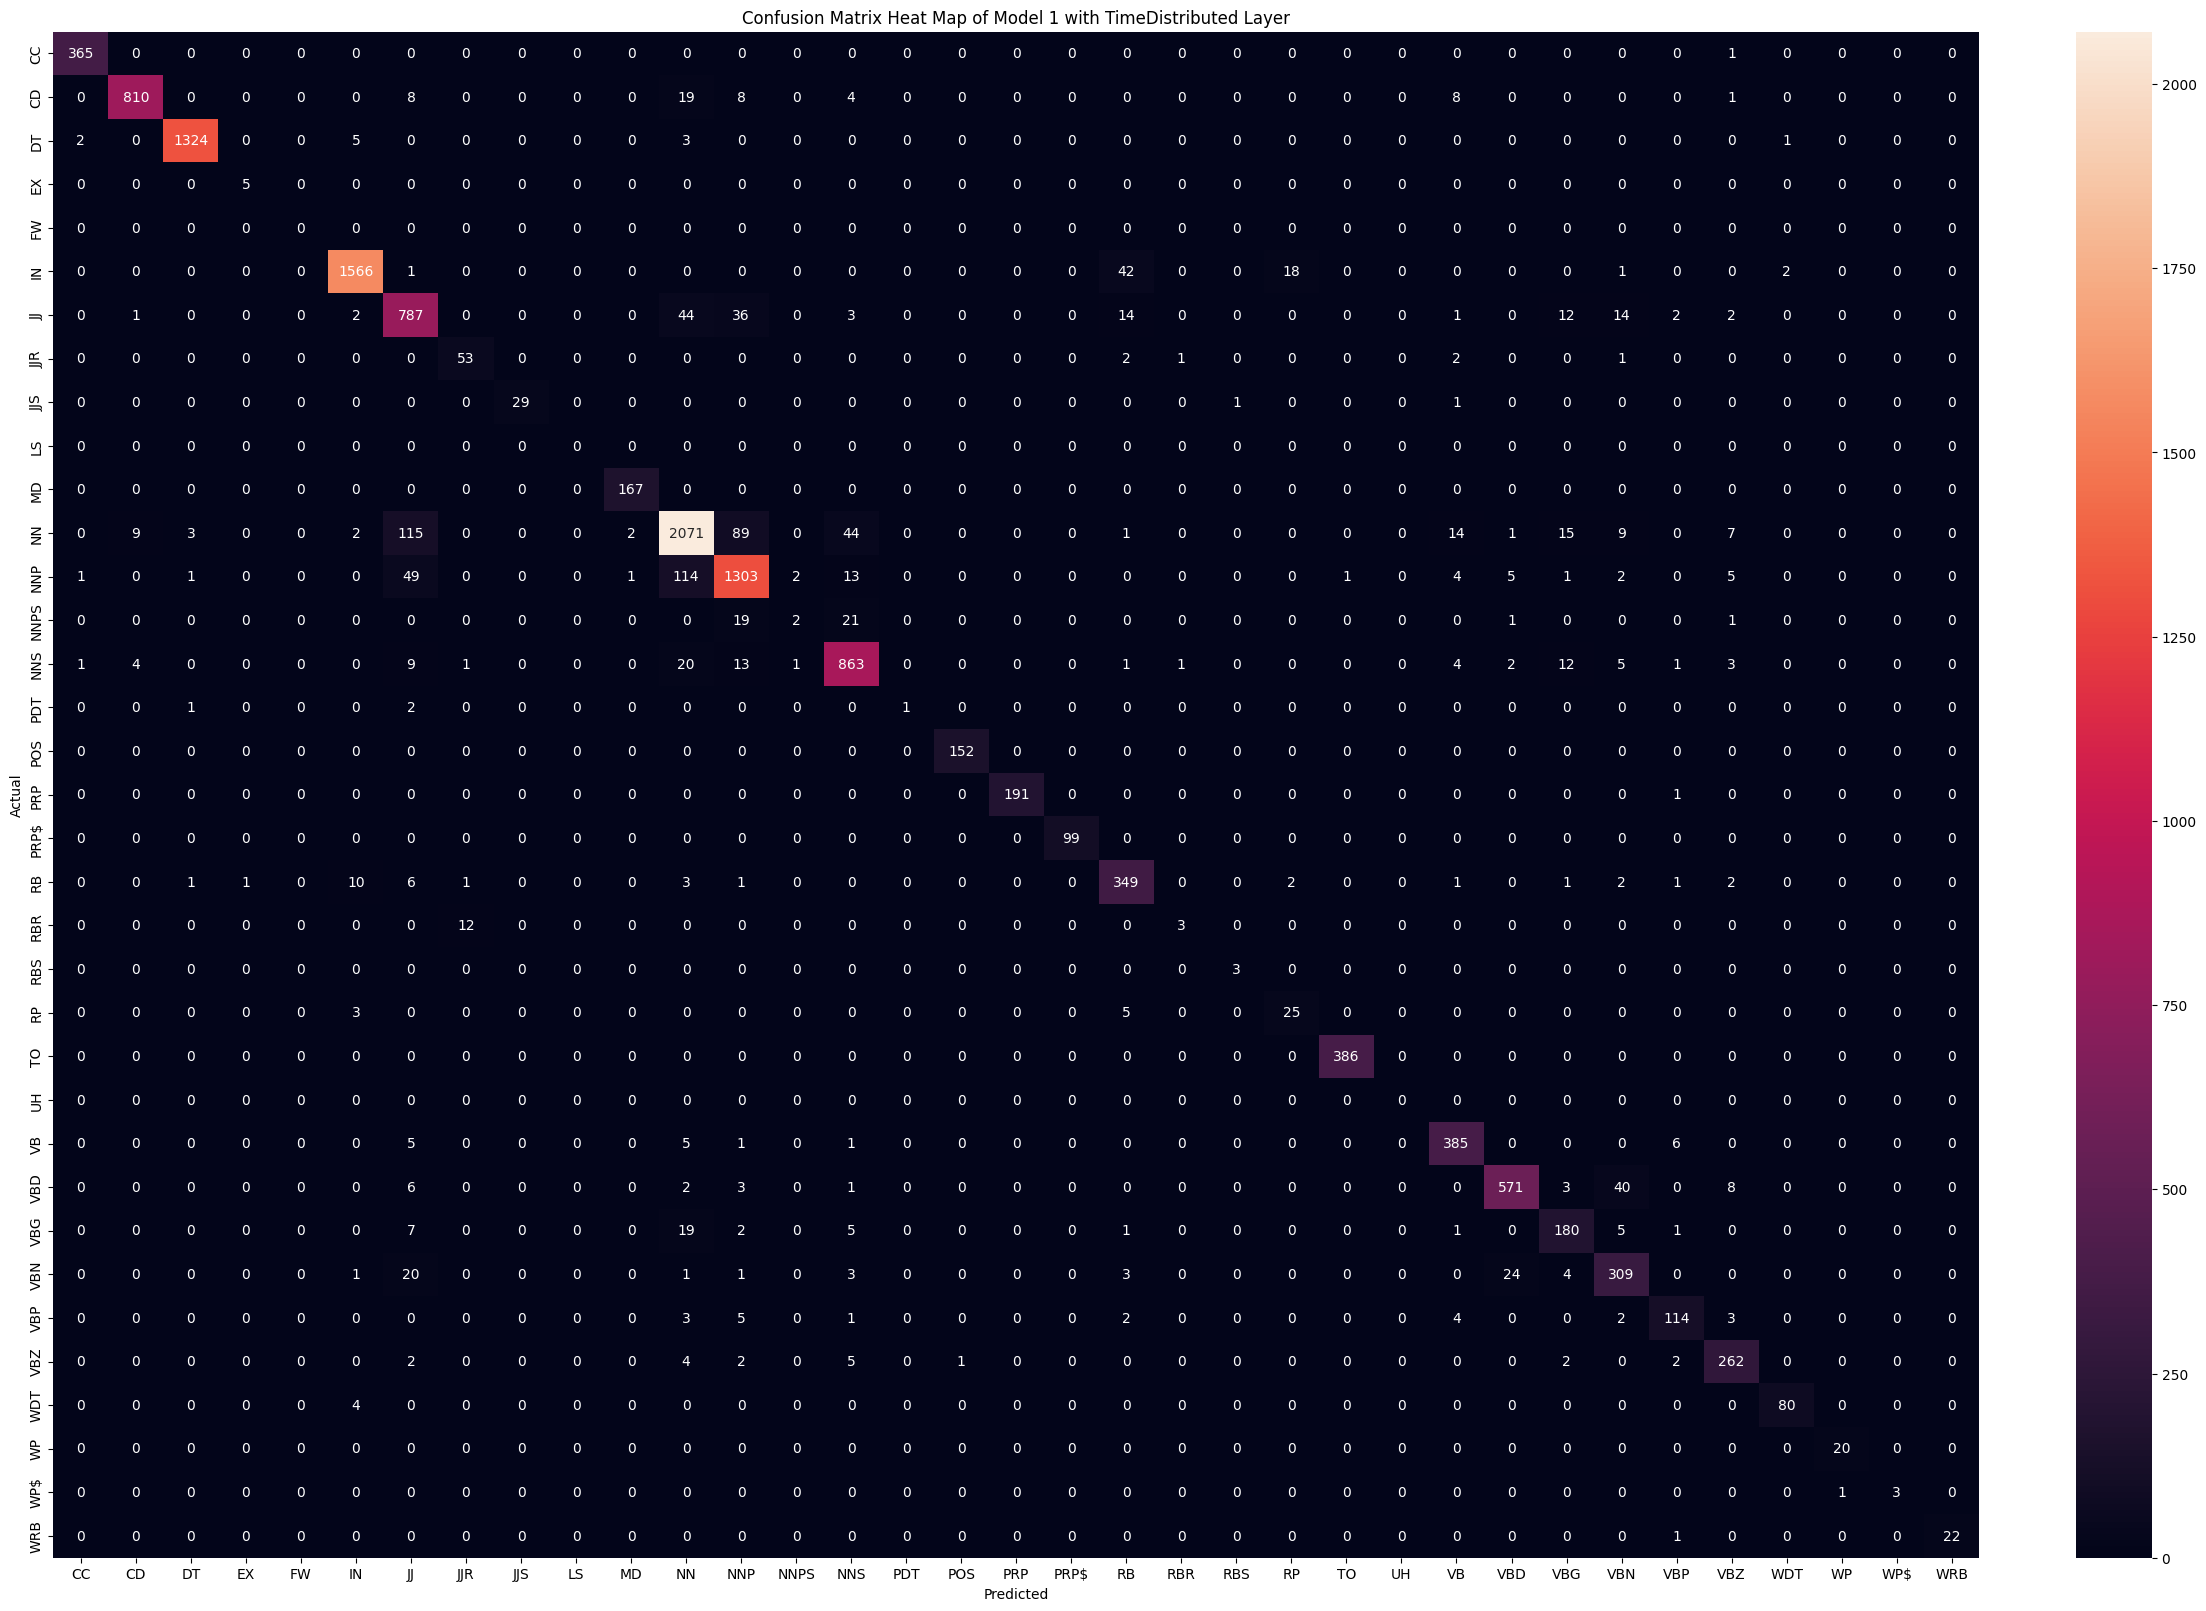

In [ ]:
cm = confusion_matrix(y_true_test_inv2, y_pred_test_inv2, labels = classes_without_punctuation)
fig, ax = plt.subplots(figsize=(22,16), layout = 'constrained')
sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes_without_punctuation, yticklabels=classes_without_punctuation)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heat Map of Model 1 with TimeDistributed Layer')
plt.show(block=False)

####Let's see the **False Negatives** and **False Positives** about the **NNPS**.

We want to know how the model misclassified them.

In [ ]:
# Modified version of the function "misclassified_samples" below

def misclassified_nnps(x_test, y_true, y_pred):
  indexes = np.where(y_true != y_pred)
  data = tokenizer.sequences_to_texts([x_test.flatten()[indexes][:]])
  words = [words for segments in data for words in segments.split()]
  true_labels = label_encoder.inverse_transform(y_true[indexes])[:]
  wrong_labels = label_encoder.inverse_transform(y_pred[indexes])[:]
  d = {'Misclassified Words': words, 'Correct Labels': true_labels, 'Predicted Labels': wrong_labels }

  misclassified_df = pd.DataFrame(data=d)

  return misclassified_df



#Function to find the False Negatives and False Positives in the 2 sets

def findNNPS(val_NNPS, test_NNPS):

    val_error = {}
    test_error = {}

    for word in val_NNPS:
        val_error[word] = val_error.get(word, 0) + 1

    for word in test_NNPS:
        test_error[word] = test_error.get(word, 0) + 1

    sorted_val_error = sorted(val_error.items(), key=lambda x:x[1], reverse=True)
    val_error = dict(sorted_val_error)

    sorted_test_error = sorted(test_error.items(), key=lambda x:x[1], reverse=True)
    test_error = dict(sorted_test_error)


    return val_error, test_error

In [ ]:
test_miss = misclassified_nnps(x_test, y_true_test, y_pred_test)
val_miss = misclassified_nnps(x_val, y_true_val, y_pred_val)

We look for the **False Negatives**

In [ ]:
# We look for the false negatives
fn_test_NNPS = (test_miss[(test_miss['Correct Labels']=='NNPS') & (test_miss['Predicted Labels']!='NNPS') &
                          (np.logical_not(test_miss['Predicted Labels'].isin(punctuation_classes)))])['Predicted Labels']

fn_val_NNPS = (val_miss[(val_miss['Correct Labels']=='NNPS') & (val_miss['Predicted Labels']!='NNPS') &
                        (np.logical_not(val_miss['Predicted Labels'].isin(punctuation_classes)))])['Predicted Labels']

fn_val_error, fn_test_error = findNNPS(fn_val_NNPS, fn_test_NNPS)
print('Distribution of the False Negatives in the val set: ', fn_val_error, '\nDistribution of the False Negatives in the test set: ', fn_test_error)

Distribution of the False Negatives in the val set:  {'NNP': 47, 'NNS': 43, 'JJ': 2, 'NN': 1, 'IN': 1} 
Distribution of the False Negatives in the test set:  {'NNP': 19, 'NNS': 19, 'VBZ': 1, 'NN': 1, 'VBP': 1, 'JJ': 1}


We do the same thing for the **False Positives**

In [ ]:
#Let's see now the False Positive case
fp_test_NNPS = (test_miss[(test_miss['Correct Labels']!='NNPS') & (test_miss['Predicted Labels']=='NNPS') &
                          (np.logical_not(test_miss['Correct Labels'].isin(punctuation_classes)))])['Correct Labels']

fp_val_NNPS = (val_miss[(val_miss['Correct Labels']!='NNPS') & (val_miss['Predicted Labels']=='NNPS') &
                        (np.logical_not(val_miss['Correct Labels'].isin(punctuation_classes)))])['Correct Labels']

fp_val_error, fp_test_error = findNNPS(fp_val_NNPS, fp_test_NNPS)
print('Distribution of the False Positives in the val set: ', fp_val_error, '\nDistribution of the False Positives in the test set: ', fp_test_error)

Distribution of the False Positives in the val set:  {'NNS': 4, 'NNP': 1} 
Distribution of the False Positives in the test set:  {'NNP': 3, 'NNS': 1}


It's evident that the model predominantly categorizes the terms as nouns in the majority of errors, involving both false positives and false negatives.

Meaning that the decision boundaries between these classes weren't learned well by the classifier.

####Now we will dive deeper on the Error Analysis to see the other mistakes our model made

In [ ]:
def plot_precision_recall_curve(y_true_transformed, y_pred, list_classes):

  binary_y_test = label_binarize(y_true_transformed, classes=[item for item in range(0,num_classes)])
  y_score = y_pred.reshape(binary_y_test.shape)

  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in list_classes:
      precision[i], recall[i], _ = precision_recall_curve(binary_y_test[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(binary_y_test[:, i], y_score[:, i])

  # setup plot details
  _, ax = plt.subplots(figsize=(8, 10))

  for i in list_classes:
      display = PrecisionRecallDisplay(
          recall=recall[i],
          precision=precision[i],
          average_precision=average_precision[i]
      )
      display.plot(ax=ax, name = label_encoder.classes_[i])



Precision/Recall Curve of Model1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.



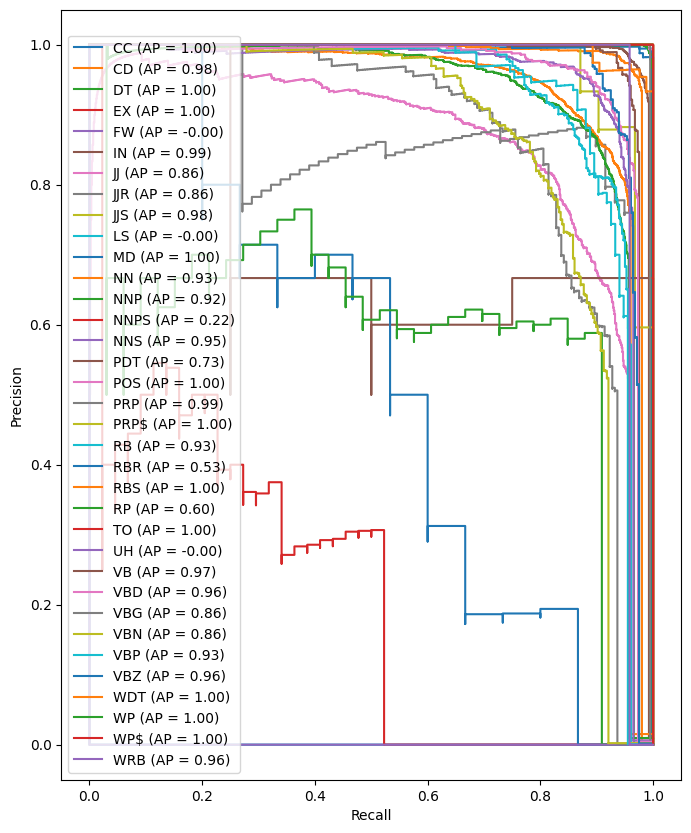

In [ ]:
print("Precision/Recall Curve of Model1")
plot_precision_recall_curve(y_true_test, y_pred, np.where(np.in1d(label_encoder.classes_ , classes_without_punctuation))[0]);

Precision/Recall Curve of Model1 with TimeDistributed Layer


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.



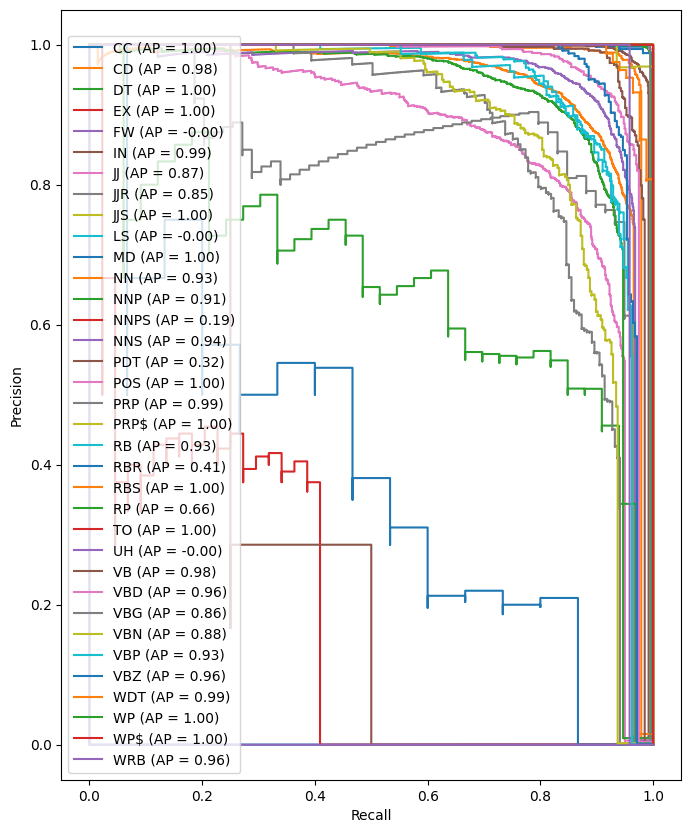

In [ ]:
print("Precision/Recall Curve of Model1 with TimeDistributed Layer")
plot_precision_recall_curve(y_true_test2, y_pred_timedist, np.where(np.in1d(label_encoder.classes_ , classes_without_punctuation))[0]);

In [ ]:
def plot_wrong_pred(y_true, y_pred):
  wrong_preds = y_true[np.where(y_true != y_pred)]
  pred_df = pd.DataFrame(columns=['wrong_predictions'], data=wrong_preds)

  pred_df['wrong_predictions'] = label_encoder.inverse_transform(pred_df['wrong_predictions'])
  pred_distribution = pred_df.groupby('wrong_predictions').size().sort_values(ascending=False)

  plt.figure(figsize=(12, 6))

  sns.set(style="whitegrid")

  # Plot the bar chart
  pred_distribution.plot(kind='bar', color='skyblue')

  plt.title('Wrong Predictions Distribution')
  plt.xlabel('POS')
  plt.ylabel('Wrong Prediction')
  plt.show()

Wrong Predictions Distribution w.r.t POS tags for Model1


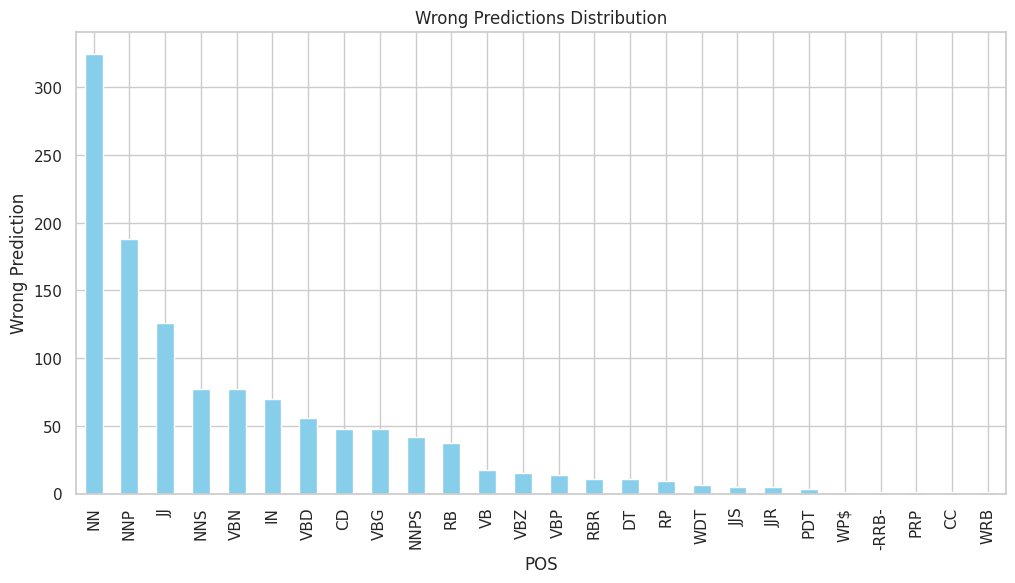

In [ ]:
print("Wrong Predictions Distribution w.r.t POS tags for Model1")
plot_wrong_pred(y_true_test, y_pred_test)

As it is seen from the graph above, NN and NNP classes have the highest number of wrong predictions. The confusion matrix also shows that the model confuses the samples of these two classes frequently. Let's see some examples of these wrong predictions.

In [ ]:
def misclassified_samples(x_test, y_true, y_pred, num_sample):
  indexes = np.where(y_true != y_pred)
  data = tokenizer.sequences_to_texts([x_test.flatten()[indexes][:num_sample]])
  words = [words for segments in data for words in segments.split()]
  true_labels = label_encoder.inverse_transform(y_true[indexes])[:num_sample]
  wrong_labels = label_encoder.inverse_transform(y_pred[indexes])[:num_sample]
  d = {'Misclassified Words': words, 'Correct Labels': true_labels, 'Predicted Labels': wrong_labels }

  misclassified_df = pd.DataFrame(data=d)

  return misclassified_df

In [ ]:
misclassified_df = misclassified_samples(x_test, y_true_test, y_pred_test, 1000)
misclassified_df [(misclassified_df ['Correct Labels']=='NN') & (misclassified_df ['Predicted Labels']=='NNP') ]

,Misclassified Words,Correct Labels,Predicted Labels
57,home,NN,NNP
98,steel,NN,NNP
113,red,NN,NNP
118,investor,NN,NNP
139,UNK,NN,NNP
...,...,...,...
801,symbol,NN,NNP
803,business,NN,NNP
905,co-author,NN,NNP
909,co-author,NN,NNP


Now, let's analyze a specific wrong predicted word and try to understand the reason

In [ ]:
misclassified_df[misclassified_df['Misclassified Words']=='world']

,Misclassified Words,Correct Labels,Predicted Labels
251,world,NN,NNP
273,world,NN,NNP
310,world,NN,NNP


Checking the data for this example in the training set

In [ ]:
train_df[(train_df['Word']=='world') & (train_df['POS']=='NNP')]

,Sentence_ID,Word,POS,Encoded_POS
6830,477,world,NNP,20
21740,1313,world,NNP,20
21890,1318,world,NNP,20
21895,1318,world,NNP,20
29677,1982,world,NNP,20
31803,2067,world,NNP,20
36018,2732,world,NNP,20
36094,2736,world,NNP,20
36284,2918,world,NNP,20
44648,3472,world,NNP,20


In [ ]:
train_df[(train_df['Word']=='world') & (train_df['POS']=='NN')]

,Sentence_ID,Word,POS,Encoded_POS
1377,129,world,NN,19
1825,146,world,NN,19
2893,217,world,NN,19
5331,417,world,NN,19
7633,505,world,NN,19
7991,525,world,NN,19
10238,638,world,NN,19
30525,2022,world,NN,19
32848,2376,world,NN,19
34274,2620,world,NN,19


The label distribution of this word in the training set, classified as NNP for 10 times and NN for 12 times, shows the inherent difficulty in distinguishing this word according to the context.


Lastly, we can check the precision/recall curve of the 3 most and least frequent classes in test set

In [ ]:
test_tag_distibution = test_df['POS'].value_counts()
tag_without_punc = test_tag_distibution.drop(labels=punctuation_classes, errors ='ignore')
most_frequent_class = list(tag_without_punc.index[0:3])
least_frequent_class = list(tag_without_punc.index[-3:])
print(f"3 Most Frequent Classes in Test Set is {most_frequent_class}")
print(f"3 Least Frequent Classes in Test Set is {least_frequent_class}")

3 Most Frequent Classes in Test Set is ['NN', 'IN', 'NNP']
3 Least Frequent Classes in Test Set is ['PDT', 'WP$', 'RBS']


In [ ]:
label_most_frequent_class = list((label_encoder.classes_[:, None] == most_frequent_class).argmax(axis=0))
label_least_frequent_class = list((label_encoder.classes_[:, None] == least_frequent_class).argmax(axis=0))

Precision/Recall Curve of Model1 for 3 Most Frequent Classes


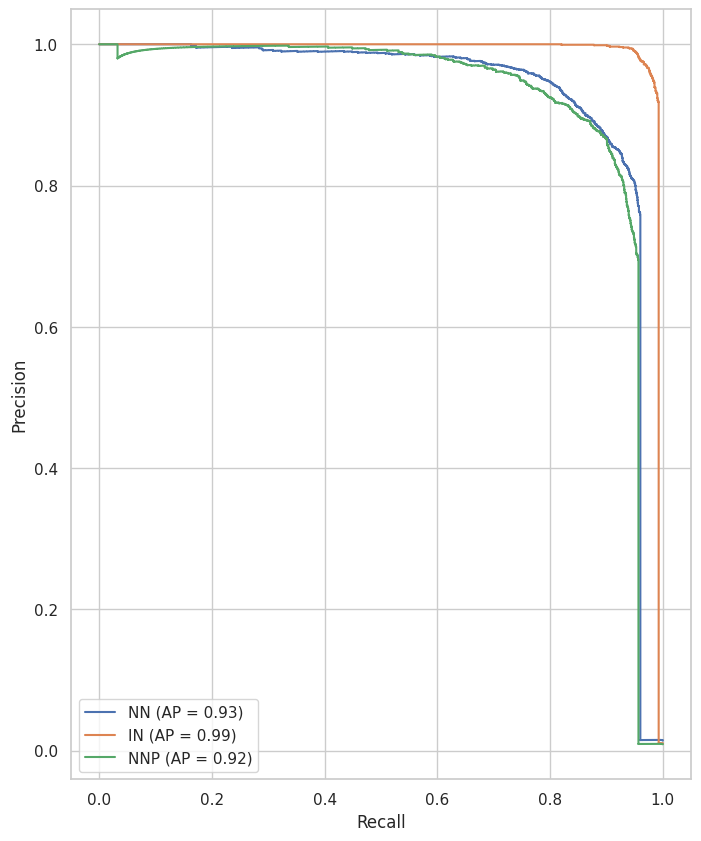

In [ ]:
print("Precision/Recall Curve of Model1 for 3 Most Frequent Classes")
plot_precision_recall_curve(y_true_test, y_pred, label_most_frequent_class);

Precision/Recall Curve of Model1 for 3 Least Frequent Classes


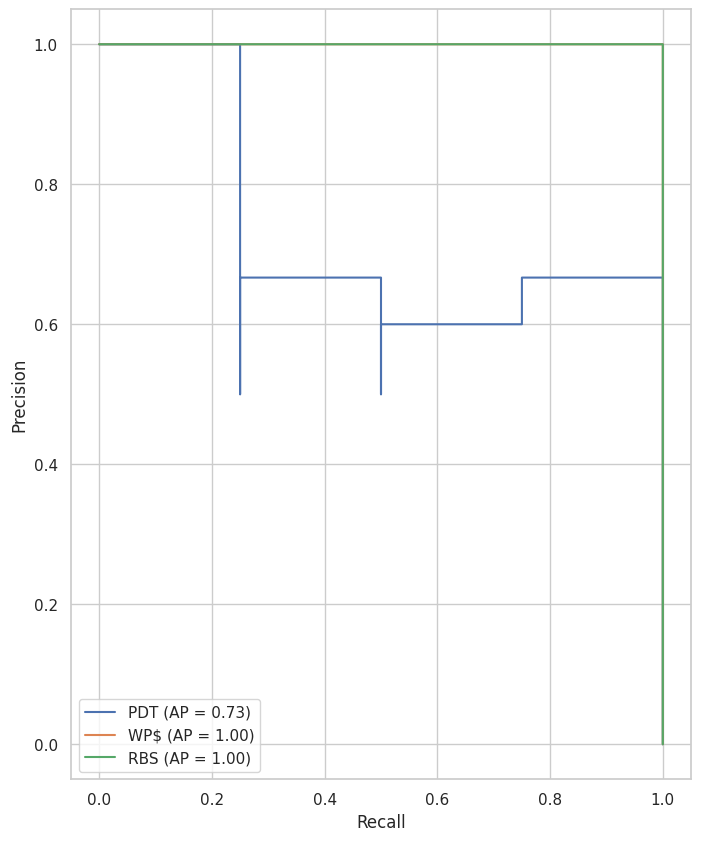

In [ ]:
print("Precision/Recall Curve of Model1 for 3 Least Frequent Classes")
plot_precision_recall_curve(y_true_test, y_pred, label_least_frequent_class);

While the first graph for the 3 most frequent classes gives a smoother curve with high precision and high recall, the second graph shows some pecularities of our model. Specifically, PDT class has high precision and low recall. By looking at the classification results, it is seen that this class has only 4 samples in the test set and we can conclude that these highly imbalanced classes makes it more difficult for our model to learn the classification boundaries well.